In [1]:
import tensorflow as tf
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np
from keras.callbacks import LambdaCallback


## Chargement du dataset de noms/types/stats

In [2]:
df = pd.read_csv('PokeDataset.csv')


In [3]:
df = df[['Name', 'Type1', 'Type2', 'HP', 'Attack',
         'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]


In [4]:
df.head()


,Name,Type1,Type2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,Bulbasaur,Grass,Poison,45,49,49,65,65,45
1,Ivysaur,Grass,Poison,60,62,63,80,80,60
2,Venusaur,Grass,Poison,80,82,83,100,100,80
3,Charmander,Fire,NaN,39,52,43,60,50,65
4,Charmeleon,Fire,NaN,58,64,58,80,65,80


In [5]:
names = df['Name'].values
print(names[:5])


['Bulbasaur' 'Ivysaur' 'Venusaur' 'Charmander' 'Charmeleon']


### Map charactères

In [6]:
names_duplicates = list(map(lambda s: s.split('-')[0], names))
names = list(set(names_duplicates))
names = list(map(lambda s: s + '.', names))
names = list(map(lambda s: s.lower(), names))
# remove '
names = list(map(lambda s: s.replace("'", ''), names))
# remove numbers
names = list(map(lambda s: ''.join([i for i in s if not i.isdigit()]), names))
# remove :
names = list(map(lambda s: s.replace(":", ''), names))
# change é to e
names = list(map(lambda s: s.replace("é", 'e'), names))
# remove ♂ and ♀
names = list(map(lambda s: s.replace("♂", ''), names))
names = list(map(lambda s: s.replace("♀", ''), names))


In [7]:
char_to_index = dict((chr(i+96), i) for i in range(1, 27))
char_to_index[' '] = 0
char_to_index['.'] = 27

index_to_char = dict((i, chr(i+96)) for i in range(1, 27))
index_to_char[0] = ' '
index_to_char[27] = '.'

max_char = len(max(names, key=len))
m = len(names)
char_dim = len(char_to_index)


### Map types

In [8]:
type_dim = 18
type_dict = {'Normal': 1, 'Fire': 2, 'Water': 3, 'Electric': 4, 'Grass': 5, 'Ice': 6, 'Fighting': 7, 'Poison': 8, 'Ground': 9,
             'Flying': 10, 'Psychic': 11, 'Bug': 12, 'Rock': 13, 'Ghost': 14, 'Dragon': 15, 'Dark': 16, 'Steel': 17, 'Fairy': 18}


### Map stats

In [43]:
stats_dim = 6
stats = df[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']].values
stats = (stats - stats.mean(axis=0)) / stats.std(axis=0)
print(stats[:5])


[[-0.93086301 -0.94855447 -0.78768439 -0.15621768 -0.18050015 -0.76499173]
 [-0.36777359 -0.5114464  -0.3081211   0.3527496   0.38170735 -0.24142719]
 [ 0.38301231  0.16102755  0.3769693   1.03137264  1.13131736  0.45665887]
 [-1.15609878 -0.84768338 -0.99321151 -0.32587344 -0.74270766 -0.06690567]
 [-0.44285218 -0.44419901 -0.47939371  0.3527496  -0.18050015  0.45665887]]


### Création des X et Y
X est le concaténation d'un charactère (28), des types (18) et des stats (6) répétées jusqu'à la fin du nom du Pokémon (max_char=13)<br>
Y est le charactère suivant celui de X dans le nom du Pokémon

In [10]:
X = np.zeros((m, max_char, char_dim + type_dim + stats_dim))
Y = np.zeros((m, max_char, char_dim))

for i in range(m):
    name = list(names[i])
    type1 = df.iloc[i]['Type1']
    type2 = df.iloc[i]['Type2']
    for j in range(len(name)):
        X[i, j, char_to_index[name[j]]] = 1
        if j < len(name)-1:
            Y[i, j, char_to_index[name[j+1]]] = 1
            # add type info
            X[i, j, char_dim + type_dict[type1] - 1] = 1
            # there isn't always a second type
            try:
                X[i, j, char_dim + type_dict[type2] - 1] = 1
            except:
                pass
            # add stats info
            X[i, j, char_dim + type_dim:] = stats[i, :]


In [11]:
X.shape, Y.shape


((1009, 13, 52), (1009, 13, 28))

## Modèle

In [12]:
model = Sequential()
model.add(LSTM(128, input_shape=(max_char, char_dim +
          type_dim + stats_dim), return_sequences=True))
model.add(Dense(char_dim, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')


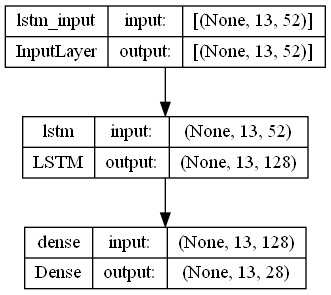

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)


In [14]:
def make_name(model, types=np.zeros((1, type_dim)), stats=np.zeros((1, stats_dim))):

    name = []
    x = np.zeros((1, max_char, char_dim))

    types = np.tile(types, (1, max_char, 1))
    x = np.concatenate((x, types), axis=2)

    stats = np.tile(stats, (1, max_char, 1))
    x = np.concatenate((x, stats), axis=2)

    end = False
    i = 0

    while end == False:
        probs = list(model.predict(x, verbose=0)[0, i])
        probs = probs / np.sum(probs)
        index = np.random.choice(range(char_dim), p=probs)
        if i == max_char-2:
            character = '.'
            end = True
        else:
            character = index_to_char[index]
        name.append(character)
        x[0, i+1, index] = 1
        i += 1
        if character == '.':
            end = True

    print(''.join(name))


In [16]:
def train(epoch, _):
    if epoch % 25 == 0:

        print('Names generated after epoch %d:' % epoch)

        for _ in range(3):
            types = np.zeros((1, type_dim))
            types[0][np.random.randint(0, type_dim)] = 1
            stats = np.random.randn(1, stats_dim)
            make_name(model, types=types, stats=stats)

        print()

name_generator = LambdaCallback(on_epoch_end=train)

model.fit(X, Y, batch_size=64, epochs=500,
          callbacks=[name_generator], verbose=0)


Names generated after epoch 0:
rstppm.
lqgltnzrloh.
tcyqbu.

Names generated after epoch 25:
baggelz.
ymobwetzehi.
ngtmklors.

Names generated after epoch 50:
losfb.
.
gmurka.

Names generated after epoch 75:
srourasckeu.
hntroc.
 ngvalt.

Names generated after epoch 100:
vulpul ik s.
yangu.
ecrc iha.

Names generated after epoch 125:
 ubltlpu.
roogv.
optekenoaex.

Names generated after epoch 150:
maapln.
atizbrs.
owgerez.

Names generated after epoch 175:
frifw.
pomup.
hinmtfslsfm.

Names generated after epoch 200:
xrreo.
agid.
urvabuto.

Names generated after epoch 225:
ceazitrmzoz.
ladokousa.
ulrolw.

Names generated after epoch 250:
raplleltcaf.
saloaretws.
avann.

Names generated after epoch 275:
ulbafyiingc.
jolt.
vinlecwe.

Names generated after epoch 300:
zgamgeae.
mosk.
yenn.

Names generated after epoch 325:
xilu.
aos b.
n.

Names generated after epoch 350:
fabenedk.
flleto.
etagceen.

Names generated after epoch 375:
yqluenakoze.
araufyf.
atonenk.

Names generated after epoc

## Tests

In [42]:
types_ = np.zeros((1, type_dim))
types_[0][type_dict['Fire'] - 1] = 1
stats_ = np.random.randn(1, stats_dim)
make_name(model, types=types_, stats=stats_)


 carapeena.


In [31]:
model.save('model_namegen_500_type_stat.h5')


In [32]:
model = tf.keras.models.load_model('model_namegen_500_type_stat.h5')


In [33]:
# evaluate the model
model.evaluate(X, Y, verbose=0)


0.7862266898155212

In [60]:
# try to recreate "Pikachu"
pikachu = np.zeros((1, max_char, char_dim + type_dim + stats_dim))
pikachu[0, 0, char_to_index['p']] = 1
# set type
pikachu[0, :, char_dim + type_dict['Electric'] - 1] = 1
# set stats
pikachu[0, :, char_dim + type_dim:] = stats[25, :]

name = ['p']
end = False
i = 1
while end == False:
    probs = list(model.predict(pikachu, verbose=0)[0, i])
    probs = probs / np.sum(probs)
    index = np.random.choice(range(char_dim), p=probs)
    if i == max_char-2:
        character = '.'
        end = True
    else:
        character = index_to_char[index]
    name.append(character)
    pikachu[0, i+1, index] = 1
    i += 1
    if character == '.':
        end = True

print(''.join(name))


pilpoxi.
